In [1]:
import numpy as np
from obspy import read
from obspy.io.xseed import Parser
from obspy.imaging.spectrogram import _nearest_pow_2
from scipy import signal
import obspy
import matplotlib.pyplot as plt
from IPython.display import Image

from matplotlib import mlab, transforms
plt.rcParams['image.cmap'] = 'magma'
import math as M
import matplotlib as mpl
import numpy.ma as ma
import time as time

## Set Parameter for Station, Date, Filters

In [2]:
station = 'KNR07' ## Station
component = 'BHZ'
component1 = 'BH1'## Component
component2 = 'BH2'
year = 2017
start_day = '050'
#start_day = str(start_day)
year= str(year)
decimate_factor = 2
pre_filt=(.001,.005,12,15) ## Parameter for filtering during response remove
#pre_filt=(.005,.006,10,12) ## Parameter for filtering during response remove
freq_min_bandpass = 1.5 ## filtercorners for filtering after response remove
freq_max_bandpass = 10 ## filtercorners for filtering after response remove
#per_lap = .9


In [4]:
st_BHZ = read('/data/cen/u254/Essing/AWI/KNIPA_NEW/' + year + '/1B/' + station + '/' + component + '.D/1B.' + station + '..' + component + '.D.' + year + '.' + start_day)
resp_file = ('/data/cen/u254/Essing/AWI/CAL/RESP.1B.' + station + '..' + component)

#st_BH1 = read('/data/cen/u254/Essing/AWI/KNIPA_NEW/' + year + '/1B/' + station + '/' + component1 + '.D/1B.' + station + '..' + component1 + '.D.' + year + '.' + start_day)
#resp_file1 = ('/data/cen/u254/Essing/AWI/CAL/RESP.1B.' + station + '..' + component1)

st_BH2 = read('/data/cen/u254/Essing/AWI/KNIPA_NEW/' + year + '/1B/' + station + '/' + component2 + '.D/1B.' + station + '..' + component2 + '.D.' + year + '.' + start_day)
resp_file2 = ('/data/cen/u254/Essing/AWI/CAL/RESP.1B.' + station + '..' + component2)

#st_BHZ = read('/home/david/AWI/' + year + '/1B/' + station + '/' + component + '.D/1B.' + station + '..' + component + '.D.' + year + '.' + start_day)
#resp_file = ('/home/david/AWI/CAL/RESP.1B.' + station + '..' + component)

In [ ]:
st_BHZ = st_BHZ.decimate(factor=decimate_factor)
fs = int(st_BHZ[0].stats.sampling_rate)
st_BHZ_simu = st_BHZ.copy()
st_BHZ_simu.simulate(paz_remove=None, pre_filt=pre_filt, seedresp={'filename': resp_file, 'units': 'DIS'})


st_BHZ_simu_filt = st_BHZ_simu.copy()
st_BHZ_simu_filt = st_BHZ_simu_filt.filter('bandpass',freqmin=freq_min_bandpass, freqmax=freq_max_bandpass)
#st_BHZ_simu_filt.merge()
data_BHZ = np.array(st_BHZ_simu_filt[0].data)
data_BHZ -= data_BHZ.mean()


npts = len(data_BHZ) ## number of datapts
wlen = float(fs*3) ## wlen for calculation of spectrogram 
nfft = int(_nearest_pow_2(wlen * fs)) ## nfft?


# hanning window is set to default in mlab.specgram  
specgram_BHZ, freq, time = mlab.specgram(data_BHZ, Fs=fs, NFFT=nfft)
#specgram_BHZ_overlab, freq, time = mlab.specgram(data_BHZ, Fs=fs, NFFT=nfft, noverlap=0.1)
#specgram_BHZ_nonoverlab, freq, time = mlab.specgram(data_BHZ, Fs=fs, NFFT=nfft)

In [ ]:
st_BH1 = st_BH1.decimate(factor=decimate_factor)
fs = int(st_BH1[0].stats.sampling_rate)
st_BH1_simu = st_BH1.copy()
st_BH1_simu.simulate(paz_remove=None, pre_filt=pre_filt, seedresp={'filename': resp_file1, 'units': 'DIS'})


st_BH1_simu_filt = st_BH1_simu.copy()
st_BH1_simu_filt = st_BH1_simu_filt.filter('bandpass',freqmin=freq_min_bandpass, freqmax=freq_max_bandpass)
#st_BHZ_simu_filt.merge()
data_BH1 = np.array(st_BH1_simu_filt[0].data)
data_BH1 -= data_BH1.mean()


npts = len(data_BH1) ## number of datapts
wlen = float(fs*3) ## wlen for calculation of spectrogram 
nfft = int(_nearest_pow_2(wlen * fs)) ## nfft?


# hanning window is set to default in mlab.specgram  
specgram_BH1, freq, time = mlab.specgram(data_BH1, Fs=fs, NFFT=nfft)
#specgram_BHZ_overlab, freq, time = mlab.specgram(data_BHZ, Fs=fs, NFFT=nfft, noverlap=0.1)
#specgram_BHZ_nonoverlab, freq, time = mlab.specgram(data_BHZ, Fs=fs, NFFT=nfft)

In [5]:
st_BH2 = st_BH2.decimate(factor=decimate_factor)
fs = int(st_BH2[0].stats.sampling_rate)
st_BH2_simu = st_BH2.copy()
st_BH2_simu.simulate(paz_remove=None, pre_filt=pre_filt, seedresp={'filename': resp_file2, 'units': 'DIS'})


st_BH2_simu_filt = st_BH2_simu.copy()
st_BH2_simu_filt = st_BH2_simu_filt.filter('bandpass',freqmin=freq_min_bandpass, freqmax=freq_max_bandpass)
#st_BHZ_simu_filt.merge()
data_BH2 = np.array(st_BH2_simu_filt[0].data)
data_BH2 -= data_BH2.mean()


npts = len(data_BH2) ## number of datapts
wlen = float(fs*3) ## wlen for calculation of spectrogram 
nfft = int(_nearest_pow_2(wlen * fs)) ## nfft?


# hanning window is set to default in mlab.specgram  
specgram_BH2, freq, time = mlab.specgram(data_BH2, Fs=fs, NFFT=nfft)
#specgram_BHZ_overlab, freq, time = mlab.specgram(data_BHZ, Fs=fs, NFFT=nfft, noverlap=0.1)
#specgram_BHZ_nonoverlab, freq, time = mlab.specgram(data_BHZ, Fs=fs, NFFT=nfft)

/home/zmaw/u300967/.conda/envs/vgseis_2018/lib/python3.6/site-packages/obspy/signal/detrend.py:31: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(data.dtype, float):


In [ ]:
print(len(freq))

## Plotting Specgram |

In [ ]:
fig = plt.figure(figsize=(16,8))

ax = fig.add_subplot(1, 1, 1)

# Major ticks every 1, minor ticks every .5

major_ticks =  np.linspace(0, 25, 26)
minor_ticks = np.linspace(0, 25, 51)

#ax.set_xticks(major_ticks)
#ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)

# And a corresponding grid
ax.grid(which='both')

ax.pcolormesh(time/3600, freq, 10*np.log10(specgram_BHZ), cmap='inferno')

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.8)
ax.grid(alpha=.49)


ax.set_xlabel('Time [h]')
ax.set_ylabel('Frequency [Hz]')
ax.set_title(station + '.' + component + '_' + 'starttime: ' +  str(st_BHZ[0].stats.starttime)[0:19])
#plt.savefig(fname = (station + '.' + component + '_' + 'starttime:_' +  str(st_BHZ[0].stats.starttime)[0:19]+ 'TEST.png'))


plt.show()

In [ ]:
print(np.floor(np.shape(specgram_BHZ)[1]/24*10))
print(np.shape(specgram_BHZ))
print(np.shape(freq))

In [ ]:
hour = np.linspace(5, 14, 91)
for i in range(len(hour)):
    print(((hour[i])))

In [ ]:
hour = [21.4,21.6]
import matplotlib.gridspec as gridspec

#hour = np.linspace(5, 14, 91)
#hour = np.linspace(3, 3.6, 6)
#hour = [13.0,13.4,14.0,14.4,14.8,15.2, 15.6]

major_ticks =  np.linspace(0, 4, 9)
minor_ticks = np.linspace(0, 4, 9)

for i in range(len(hour)):
    #print(((hour[i])))


    number_of_fft = int(np.floor(np.shape(specgram_BHZ)[1]/24*hour[i]))




    fig= plt.figure(figsize=(16,12))
    gs = gridspec.GridSpec(nrows=2, ncols=3, height_ratios=[1, 2])


    #f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False, figsize=(16,8))
    ax2 = fig.add_subplot(gs[0, :])
    ax2.semilogy(freq, specgram_BHZ[:,number_of_fft], label='BHZ')
    ax2.set_title('Components')
    ax2.semilogy(freq, specgram_BH1[:,number_of_fft], label='BH1')
    ax2.axvline(x=.5, linewidth=.8, color='black')
    ax2.semilogy(freq, specgram_BH2[:,number_of_fft], label='BH2')
    ax2.set_xlim(0.1,5)
    ax2.set_ylim(10e-23, 10e-10)
    ax2.set_xlabel('Frequency [Hz]')
    ax2.grid()
    ax2.legend()
    ax4 = fig.add_subplot(gs[1:, :])
    ax4.set_yticks(major_ticks)
    ax4.set_yticks(minor_ticks, minor=True)

    # And a corresponding grid
    ax4.grid(which='both')
    ax4.grid(which='minor', alpha=0.8)
    ax4.grid(which='major', alpha=0.8)
    ax4.grid(alpha=.95)
    
    
    
    ax4.set_xlabel('Time [h]')
    ax4.set_ylabel('Frequency [Hz]')
    ax4.set_title(station + '.' + component + '_' + 'starttime: ' +  str(st_BHZ[0].stats.starttime)[0:19])
    ax4.pcolormesh(time/3600, freq, 10*np.log10(specgram_BH2), cmap='inferno')
    ax4.axvline(x=hour[i], linewidth=.4, color='black')
    fig.suptitle('comparison between Components')
    #plt.savefig(fname = (station + '.' + component + '_' + 'starttime:_' +  str(st_BHZ[0].stats.starttime)[0:19]+ 'actual_hour' + str(hour[i]) +'comparison between Components.png'))
    #plt.clf()
    plt.show()

In [ ]:
minval_freq = 20
maxval_freq = 25
freq_values = freq[np.where(np.logical_and(freq>minval_freq, freq<maxval_freq))]
first_indi_to_use = np.where(freq == freq_values[0])[0]
last_indi_to_use = np.where(freq == freq_values[-1])[0]

funda_freq_amp_masekd = ma.array(specgram_BHZ)
funda_freq_amp_masekd[int(first_indi_to_use):int(last_indi_to_use),:] = ma.masked(fill_value=0)

In [ ]:
print(np.shape(specgram_BHZ)[0]/24*10)

In [ ]:
plt.plot(freq, funda_freq_amp_masekd[:,425:426])
#plt.xlim(2,12)
plt.show()

### HPS-Algorithmus to find fundamental frequency

In [6]:
def hps_algo(input_data, freq_range_input_data, min_freq, max_freq, nr_downsamp, amp_threshold=1e-45):
    '''HarmonicProductSpectrum Algorithum to obtain fundamental frequency  
    
    http://musicweb.ucsd.edu/~trsmyth/analysis/Harmonic_Product_Spectrum.html 
    
    input_data              ndarray      spectrogram with harmonic signal on it
    freq_range_input_data   ndarray      frequency values calculated from mlab.specgram
    min_freq                float        minimal frequency to mask frequency band, optional
    max_freq                float        maximal frequency to mask frequency band
    nr_dwonsamp             integer      value to downsamp 
    amp_threshold           float        value to differ between harmonic signal and noise   
    
    '''
    
    
    # mask array in given frequency band
    input_data_copy = input_data.copy()
    freq = freq_range_input_data
    
    lower_minval_freq = min_freq
    lower_maxval_freq = max_freq
    lower_freq_values = freq[np.where(np.logical_and(freq>lower_minval_freq, freq<lower_maxval_freq))]

    lower_first_indi_to_use = np.where(freq == lower_freq_values[0])[0]
    lower_last_indi_to_use = np.where(freq == lower_freq_values[-1])[0]

    input_data_masked = ma.array(input_data_copy)
    input_data_masked[int(lower_first_indi_to_use):int(lower_last_indi_to_use),:] = 0
    
    
    
    # initialize arrays to safe values
    # 2D arrays
    fund_freq_amp = np.zeros_like(input_data)
    harmonic_product_spectrum = np.zeros_like(input_data)
    #print(np.shape)
    
    # 1D arrays
    fund_freq_value = np.zeros((np.shape(input_data))[1])
    fund_freq_indi = np.zeros_like(fund_freq_value)
    fund_freq_amplitude = np.zeros_like(fund_freq_value)
    amp_fundamenteal_freq = np.zeros_like(fund_freq_value)

    
    spectrum_downsamp =  np.zeros(((np.shape(input_data_masked))[1],nr_downsamp, len(input_data_masked)))
    #print(np.shape(fund_freq_value), np.shape(fund_freq_indi), np.shape(amp_fundamenteal_freq))
    
    
    # for loop over all columns
    for j in range((np.shape(input_data_masked))[1]):
        #print((np.shape(input_data_masked))[1])
        spectrum_signal = input_data_masked[:,j]
        #print(np.shape(spectrum_downsamp))
        spectrum_downsamp[j,0,:] = spectrum_signal 
    
        # for loop to downsample every column in spectrogram
        for i in range(nr_downsamp-1):
            nr_downsamp_array = np.linspace(2,nr_downsamp, nr_downsamp-1)
            #print(nr_downsamp_array)
            spectrum_downsamp[j,i+1,:][0:len(spectrum_signal[::int(nr_downsamp_array[i])])] = spectrum_signal[::int(nr_downsamp_array[i])]
        
        harmonic_product_spectrum[:,j] = spectrum_downsamp[j,0,:] *  spectrum_downsamp[j,1,:] * spectrum_downsamp[j,2,:] * spectrum_downsamp[j,3,:]#* one_spec_downsamp[4]

        fund_freq_value[j] = freq[np.argmax(harmonic_product_spectrum[:,j])]
        fund_freq_indi = np.argmax(harmonic_product_spectrum[:,j])
        fund_freq_amplitude[j] = np.max(harmonic_product_spectrum[:,j])
    
        # Amplitude Values for Threshold handling
    
        if fund_freq_amplitude[j] < amp_threshold:

            fund_freq_value[j] = np.nan
            fund_freq_indi = np.nan
            fund_freq_amplitude[j] = np.nan

            
    return fund_freq_value, fund_freq_indi, fund_freq_amplitude

In [19]:
threshold = -57
threshold = 10**(threshold)
print(10*np.log10(threshold))

fund_freq_value, fund_freq_indi, fund_freq_amplitude  = hps_algo(input_data=specgram_BH2, freq_range_input_data=freq, min_freq=-1, max_freq=0.0001, nr_downsamp=4, amp_threshold=threshold)

-570.0


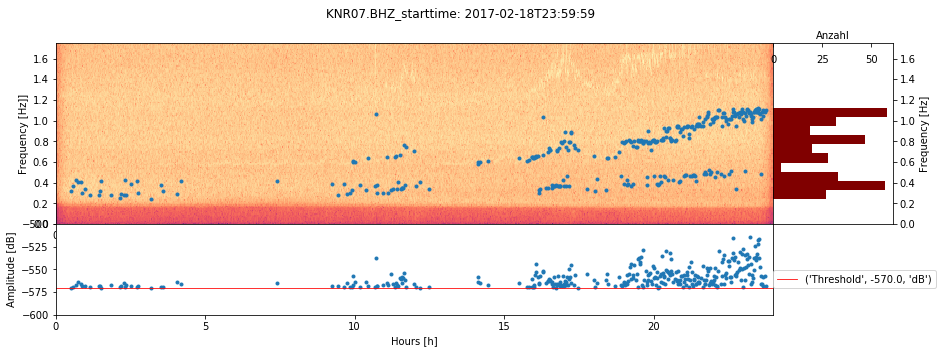

In [20]:
gridsize = (3, 7)
number_bins= 10
fig = plt.figure(figsize=(15, 5))
fig.subplots_adjust(hspace=0, wspace=0)
fig.suptitle(station + '.' + component + '_' + 'starttime: ' +  str(st_BHZ[0].stats.starttime)[0:19])
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=6, rowspan=2)
ax2 = plt.subplot2grid(gridsize, (0, 6), colspan=1, rowspan=2, sharey=ax1)
ax3 = plt.subplot2grid(gridsize, (2, 0), colspan=6, rowspan=1, sharex=ax1)

ax1.plot(time/3600,(fund_freq_value), '.')
ax1.pcolormesh(time/3600, freq,10*np.log10(specgram_BH2))
ax1.set_xlim(0,24)
ax1.set_ylim(0,1.75)
ax1.set_ylabel('Frequency [Hz]]')

ax2.hist(fund_freq_value[~np.isnan(fund_freq_value)], bins=number_bins, color='maroon', orientation='horizontal')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')
ax2.set_ylabel('Frequency [Hz]')
ax2.xaxis.tick_top()
ax2.tick_params(axis="x",direction="in", pad=-22)
ax2.xaxis.set_label_position('top')
ax2.set_xlabel('Anzahl')

ax3.plot(time/3600,10*np.log10(fund_freq_amplitude), '.')
ax3.axhline(y=(10*np.log10(threshold)), linewidth=.8, color='red', label=('Threshold', 10*np.log10(threshold), 'dB'))
ax3.set_ylim(-600,-500)
ax3.set_ylabel('Amplitude [dB]')
ax3.set_xlabel('Hours [h]')
ax3.legend(bbox_to_anchor=(1, 0.395), loc='center left', borderaxespad=0.)

plt.show()

In [ ]:
#one_spec_signal = specgram_BHZ[:,212]

threshold = 2e-40

number_of_downsampling = 3





funda_freq_amp = np.zeros_like(specgram_BHZ)
harmonic_product_spectrum = np.zeros_like(specgram_BHZ)

fundamenteal_freq = np.zeros((np.shape(specgram_BHZ))[1])
amp_fundamenteal_freq = np.zeros_like(fundamenteal_freq)
freq_value = np.zeros_like(fundamenteal_freq)

for j in range((np.shape(specgram_BHZ))[1]):
    one_spec_signal = funda_freq_amp_masekd[:,j]
    one_spec_downsamp =  np.zeros((number_of_downsampling, len(specgram_BHZ)))
    one_spec_downsamp[0] = one_spec_signal 
    #print(one_spec_signal)
    for i in range(number_of_downsampling-1):
        numbers_donwsamp = np.linspace(2,number_of_downsampling, number_of_downsampling-1)
        #print(int(numbers_donwsamp[i]))
        one_spec_downsamp[i+1][0:len(one_spec_signal[::int(numbers_donwsamp[i])])] = one_spec_signal[::int(numbers_donwsamp[i])]
        #print(one_spec_downsamp)
        
    harmonic_product_spectrum[:,j] = one_spec_signal *  one_spec_downsamp[1] * one_spec_downsamp[2]# * one_spec_downsamp[3]#* one_spec_downsamp[4]
    #print(harmonic_product_spectrum)
    
    freq_value[j] = freq[np.argmax(harmonic_product_spectrum[:,j])]
    #print(freq_value)
    freq_pos = np.argmax(harmonic_product_spectrum[:,j])
    #print(freq_pos)
    
    if np.mean(harmonic_product_spectrum[:,j]) > threshold:
        #print(np.max(harmonic_product_spectrum[:,j]))
        funda_freq_amp[freq_pos, j] =   np.max(harmonic_product_spectrum[:,j])
        #amp_fundamenteal_freq[j] = 
    else:
        funda_freq_amp[freq_pos, j] = np.NaN
        #amp_fundamenteal_freq[j] = np.NaN

In [ ]:
# Part to look up indice values for specific frequence values

#minval_freq = .0
#maxval_freq = 2
#freq_values = freq[np.where(np.logical_and(freq>minval_freq, freq<maxval_freq))]
#first_indi_to_use = np.where(freq == freq_values[0])[0]
#last_indi_to_use = np.where(freq == freq_values[-1])[0]

#funda_freq_amp_masekd = ma.array(funda_freq_amp)
#funda_freq_amp_masekd[int(first_indi_to_use):int(last_indi_to_use),:] = ma.masked


fig = plt.figure(figsize=(16,8))

ax = fig.add_subplot(1, 1, 1)

# Major ticks every 1, minor ticks every .5

major_ticks =  np.linspace(0, 12, 13)
minor_ticks = np.linspace(0, 12, 25)

#ax.set_xticks(major_ticks)
#ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)

# And a corresponding grid
ax.grid(which='both')

ax.pcolormesh(time/3600, freq, 10*np.log10(specgram_BHZ), cmap='magma')
ax.pcolormesh(time/3600, freq, 10*np.log10(funda_freq_amp), cmap='gray')
#ax.pcolormesh(time/3600, freq,10*np.log10(funda_freq_amp_masekd))

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.8)
ax.grid(alpha=.49)


ax.set_xlabel('Time [h]')
ax.set_ylabel('Frequency [Hz]')
ax.set_title(station + '.' + component + '_' + 'starttime: ' +  str(st_BHZ[0].stats.starttime)[0:19])
#plt.savefig(fname = (station + '.' + component + '_' + 'starttime:_' +  str(st_BHZ[0].stats.starttime)[0:19]+ 'TEST.png'))


plt.show()


In [ ]:
masked_BHZ = specgram_BHZ[:,937]

lower_minval_freq = 0
lower_maxval_freq = .8
lower_freq_values = freq[np.where(np.logical_and(freq>lower_minval_freq, freq<lower_maxval_freq))]

lower_first_indi_to_use = np.where(freq == lower_freq_values[0])[0]
lower_last_indi_to_use = np.where(freq == lower_freq_values[-1])[0]

funda_freq_amp_masekd = ma.array(specgram_BHZ)
funda_freq_amp_masekd[int(lower_first_indi_to_use):int(lower_last_indi_to_use),:] = ma.masked

In [ ]:
fig = plt.figure(figsize=(15, 12))
fig.subplots_adjust(hspace=0, wspace=0)
gridsize = (2, 2)
fig.suptitle('Masked/unmasked' + station + '.' + component + '_' + 'starttime: ' +  str(st_BHZ[0].stats.starttime)[0:19])
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=1, rowspan=1)
ax2 = plt.subplot2grid(gridsize, (0, 1), colspan=1, rowspan=1, sharey=ax1)
ax1.pcolormesh(time/3600, freq, 10*np.log10(funda_freq_amp_masekd))
ax2.pcolormesh(time/3600, freq, 10*np.log10(funda_freq_amp))
plt.show()

In [ ]:
fig = plt.figure(figsize=(15, 12))
fig.subplots_adjust(hspace=0, wspace=0)
gridsize = (2, 2)
fig.suptitle('Masked/unmasked' + station + '.' + component + '_' + 'starttime: ' +  str(st_BHZ[0].stats.starttime)[0:19])
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=1, rowspan=1)
ax2 = plt.subplot2grid(gridsize, (0, 1), colspan=1, rowspan=1, sharey=ax1)



ax1.plot(freq,10*np.log10(funda_freq_amp_masekd[:,937]))
ax1.set_xlim(0,1.5)
ax1.grid()
ax2.plot(freq, 10*np.log10(specgram_BHZ[:,937]))
ax2.grid()
ax2.set_xlim(0,1.5)
plt.show()

In [ ]:
first_over_tone_freq = np.nonzero(funda_freq_amp_masekd)[0]*2
second_over_tone_freq = np.nonzero(funda_freq_amp_masekd)[0]*3
third_over_tone_freq = np.nonzero(funda_freq_amp_masekd)[0]*4


amp_value = np.zeros(len(freq))
for i in range(len(freq)):
    for j in range(len(time)):
        amp_value[i] = funda_freq_amp_masekd[i,j]

In [ ]:
np.nonzero(funda_freq_amp_masekd)

In [ ]:
plt.pcolormesh(time/3600, freq,10*np.log10(funda_freq_amp_masekd))
plt.ylim(0,3)
plt.show()

In [ ]:
fig = plt.figure(figsize=(16,8))

ax = fig.add_subplot(1, 1, 1)

# Major ticks every 1, minor ticks every .5

major_ticks =  np.linspace(0, 12, 13)
minor_ticks = np.linspace(0, 12, 25)

#ax.set_xticks(major_ticks)
#ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)

# And a corresponding grid
ax.grid(which='both')

#ax.pcolormesh(time/3600, freq, 10*np.log10(specgram_BHZ), cmap='magma')
ax.pcolormesh(time/3600, freq, 10*np.log10(funda_freq_amp), cmap='gray')

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.8)
ax.grid(alpha=.49)


ax.set_xlabel('Time [h]')
ax.set_ylabel('Frequency [Hz]')
ax.set_title(station + '.' + component + '_' + 'starttime: ' +  str(st_BHZ[0].stats.starttime)[0:19])
#plt.savefig(fname = (station + '.' + component + '_' + 'starttime:_' +  str(st_BHZ[0].stats.starttime)[0:19]+ 'TEST.png'))
ax.set_xlim(10,15)
ax.set_ylim(0,1)
ax.grid()

plt.show()


In [ ]:
plt.plot(freq, sum_freq)
plt.xlabel('Freq [Hz]')
#plt.xlim(0,3)
plt.show()

## with two X-Axes for Time and Windows

In [ ]:
scale = np.linspace(0, np.shape(specgram_BHZ)[1], np.shape(specgram_BHZ)[1])

In [ ]:
print((np.shape(specgram_BHZ)[0]))

In [ ]:
fig = plt.figure(figsize=(16,8))

ax = fig.add_subplot(1, 1, 1)

# Major ticks every 1, minor ticks every .5

major_ticks =  np.linspace(0, 12, 13)
minor_ticks = np.linspace(0, 12, 25)

#ax.set_xticks(major_ticks)
#ax.set_xticks(minor_ticks, minor=True)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)

# And a corresponding grid
ax.grid(which='both')

ax.pcolormesh(time/3600, freq, 10*np.log10(funda_freq_amp), cmap='gray')


ax2 = ax.twiny()


# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.8)
ax.grid(alpha=.49)


ax.set_xlabel('Time [h]')
ax.set_ylabel('Frequency [Hz]')
ax.set_title(station + '.' + component + '_' + 'starttime: ' +  str(st_BHZ[0].stats.starttime)[0:19], pad=40)
#plt.savefig(fname = (station + '.' + component + '_' + 'starttime:_' +  str(st_BHZ[0].stats.starttime)[0:19]+ 'TEST.png'))
ax2.pcolormesh(scale, freq, 10*np.log10(funda_freq_amp), cmap='gray')
plt.show()

In [ ]:
fig = plt.figure(figsize=(16,8))

ax = fig.add_subplot(1, 1, 1)

# Major ticks every 1, minor ticks every .5

#major_ticks =  np.linspace(0, 12, 13)
#minor_ticks = np.linspace(0, 12, 25)

#ax.set_xticks(major_ticks)
#ax.set_xticks(minor_ticks, minor=True)
#ax.set_yticks(major_ticks)
#ax.set_yticks(minor_ticks, minor=True)

# And a corresponding grid
#ax.grid(which='both')

ax.pcolormesh(10*np.log10(funda_freq_amp), cmap='gray')


#ax2 = ax.twiny()


# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.8)
ax.grid(alpha=.49)
#ax.set_ylim(0,15)
ax.set_xlim(0,15)

#ax.set_xlabel('Time [h]')
#ax.set_ylabel('Frequency [Hz]')
#ax.set_title(station + '.' + component + '_' + 'starttime: ' +  str(st_BHZ[0].stats.starttime)[0:19], pad=40)
#plt.savefig(fname = (station + '.' + component + '_' + 'starttime:_' +  str(st_BHZ[0].stats.starttime)[0:19]+ 'TEST.png'))
#plt.colorbar()
plt.show()


In [ ]:
plt.plot(freq, harmonic_product_spectrum[:,8:9], label='8', color='blue')
plt.plot(freq, harmonic_product_spectrum[:,9:10], label='9', color='red')
plt.plot(freq, harmonic_product_spectrum[:,10:11], label='10', color='orange')
plt.plot(freq, harmonic_product_spectrum[:,11:12], label='11', color='green')
plt.plot(freq, harmonic_product_spectrum[:,12:13], label='12', color='yellow')
#plt.plot(freq, harmonic_product_spectrum[:,202:203],  label='singal', color='red')
#plt.semilogy(freq, harmonic_product_spectrum[:,770:771],  label='no singal', color='green')
plt.xlim(0.4,0.8)
#plt.ylim(0,2e-34)
plt.legend()
plt.show()

In [ ]:
print(np.mean(harmonic_product_spectrum[:,770:771]), 'mean of no signal')
print(np.max(harmonic_product_spectrum[:,770:771]), 'max of no signal')


print(np.mean(harmonic_product_spectrum[:,813:814]), 'mean of SIGNAL')
print(np.max(harmonic_product_spectrum[:,813:814]), 'max of  SIGNAL')



In [ ]:
#plt.semilogy(freq, specgram_BHZ[:,742])
plt.semilogy(freq, specgram_BHZ[:,743], color='red')
plt.semilogy(freq, specgram_BHZ[:,223], color='blue')

plt.show()

In [ ]:


f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(16,8))
ax1.plot(fundamenteal_freq, 'o')
ax1.set_title('freq')
#ax1.set_xlim(0,3)
ax1.grid()
ax2.semilogy((amp_fundamenteal_freq), '.')
ax2.axhline(3.5e-34, color='black', lw=1)
ax2.set_title('Amp') 
ax2.grid()
plt.show()

In [ ]:
plt.pcolormesh( 10*np.log10(one_spec_downsamp))
plt.colorbar()
plt.show()

In [ ]:
#plt.plot(freq, 10*np.log(hps))
plt.plot(freq, (hps))
plt.xlabel('Frequency [Hz]')
plt.xlim(0,3)
plt.grid()
plt.show()

In [ ]:
print(freq[np.argmax(hps)])

In [ ]:
one_spec_downsamp = 10*np.log10(one_spec_downsamp)
product = np.prod(10*np.log10(one_spec_downsamp), axis=0)    
    

In [ ]:
f, ax = plt.subplots(2, 2, sharex=False, figsize=(16,8))
ax[0, 0].plot(freq, (specgram_BHZ[:,212]))
ax[0, 0].set_title('Specgram of Signal')
ax[0, 0].set_ylim(0,5e-11)
ax[0, 0].grid()
ax[0, 1].plot(freq, (specgram_BHZ[:,659]))
ax[0, 1].set_title('Specgram of missing Signal')
ax[0, 1].set_ylim(0,5e-11)
ax[0, 1].grid()
ax[1, 0].plot(freq, (hps_spectrum_signal))
ax[1, 0].plot(freq[np.argmax(hps_spectrum_signal)], np.max(hps_spectrum_signal), '.')
ax[1, 0].set_title('Fundamental Frequency of Signal after HPS')
ax[1, 0].set_ylim(0,2e-45)
ax[1, 0].grid()
ax[1, 1].plot(freq, (hps_spectrum))
ax[1, 1].plot(freq[np.argmax(hps_spectrum)], np.max(hps_spectrum), 'o')
ax[1, 1].set_title('Fundamental Frequency of Data without Signal after HPS') 
ax[1, 1].set_ylim(0,2e-45)
ax[1, 1].grid()

plt.show()

In [ ]:
    

# downsampling by factor 2 

one_spec_downsamp_2 =  np.zeros(len(one_spec_signal))
one_spec_downsamp_2[0:len(one_spec_signal[::2])] = one_spec_signal[::2]
#hps_spectrum = one_spec_downsamp_2 * one_spec

# downsampling by factor 3

one_spec_downsamp_3 =  np.zeros(len(one_spec_signal))
one_spec_downsamp_3[0:len(one_spec_signal[::3])] = one_spec_signal[::3]

# downsampling by factor 4

one_spec_downsamp_4 =  np.zeros(len(one_spec_signal))
one_spec_downsamp_4[0:len(one_spec_signal[::4])] = one_spec_signal[::4]

# multiply all downsamps 

hps_spectrum_signal =  one_spec_signal * one_spec_downsamp_2 * one_spec_downsamp_3 *  one_spec_downsamp_4

In [ ]:
one_spec = specgram_BHZ[:,659]

# downsampling by factor 2 

one_spec_downsamp_2 =  np.zeros(len(one_spec))
one_spec_downsamp_2[0:len(one_spec[::2])] = one_spec[::2]
#hps_spectrum = one_spec_downsamp_2 * one_spec

# downsampling by factor 3

one_spec_downsamp_3 =  np.zeros(len(one_spec))
one_spec_downsamp_3[0:len(one_spec[::3])] = one_spec[::3]

# downsampling by factor 4

one_spec_downsamp_4 =  np.zeros(len(one_spec))
one_spec_downsamp_4[0:len(one_spec[::4])] = one_spec[::4]

# multiply all downsamps 

hps_spectrum =  one_spec_signal * one_spec_downsamp_2 * one_spec_downsamp_3 *  one_spec_downsamp_4

In [ ]:
fundamental_freq =  str(freq[np.argmax(hps_spectrum_signal)])

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16,8))
ax1.plot(freq, (hps_spectrum_signal))
ax1.plot(freq[np.argmax(hps_spectrum_signal)], np.max(hps_spectrum_signal), 'o')
ax1.set_title('Signal')
ax1.set_xlim(0,3)
ax1.grid()
ax2.plot(freq, (hps_spectrum))
ax2.plot(freq[np.argmax(hps_spectrum)], np.max(hps_spectrum), 'o')
ax2.set_title('No Signal') 
ax2.set_xlim(0,3)
ax2.grid()
plt.show()

In [ ]:
hps_spectrum = flattend_specgram_BHZ_downsampled * flattend_specgram_BHZ

In [ ]:
#plt.plot(freq, flattend_specgram_BHZ, color='red')
#plt.plot(freq, flattend_specgram_BHZ_downsampled, color='green')
#plt.plot(freq, 10*np.log10(hps_spectrum))
#plt.plot(freq, (hps_spectrum))
#plt.plot(freq, one_spec)
plt.plot(freq, hps_spectrum)
plt.xlim(0,3)
plt.grid()
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# Major ticks every 1, minor ticks every .5

#major_ticks =  np.linspace(0, 12, 13)
#minor_ticks = np.linspace(0, 12, 25)

#ax.set_xticks(major_ticks)
#ax.set_xticks(minor_ticks, minor=True)
#ax.set_yticks(major_ticks)
#ax.set_yticks(minor_ticks, minor=True)

# And a corresponding grid
ax.grid(which='both')

ax.plot(freq, hps_spectrum)

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)

ax.set_xlim(1,1.5)

plt.show()

In [ ]:
print( np.max(hps_spectrum))

In [ ]:
comp.decimate(factor=2)
comp_simu = comp.copy()
t = comp[0].stats.starttime
chan = (str(comp[0].stats.channel))
path = './SPECS/KNR07/' + str(chan)
path_parser = '/data/cen/u254/Essing/AWI'

if os.path.isdir(path) == False:
    os.mkdir(path)


# need to remove response before calculating spectrogram and may filter...
#print(path + '/CAL/RESP.1B.' + comp[0].stats.station + '..' + comp[0].stats.channel)
parser01 = Parser(path_parser + '/CAL/RESP.1B.' + comp[0].stats.station + '..' + comp[0].stats.channel)
print('parser finished')

#if comp[0].stats.sampling_rate == 100:
#    comp.simulate(seedresp={'filename': parser01, 'units': "ACC"})
#    comp.decimate(factor=4)
#    comp.filter('highpass', freq=1)
#else:
comp_simu.simulate(seedresp={'filename': parser01, 'units': "ACC"})
comp_simu.filter('highpass', freq=1)
    
    
start = time.time()
comp_simu.trim(starttime=t+0*3600, endtime=t+24*3600)
comp_simu.spectrogram(dbscale=True, log=False, wlen=360, outfile=(path + '/' + comp[0].stats.station + '.' + comp[0].stats.channel + '_' + str(comp[0].stats.starttime) + '.png'), show=0  ) #what values would be good for wlen? per_lap still not works
end = time.time()

In [ ]:
path = '/data/cen/u254/Essing/AWI'
st = read(path + '/KNIPA_NEW/2017/1B/KNR01/BHZ.D/1B.KNR01..BHZ.D.2017.001')
st.decimate(factor=2)
#parser_path = path + '/CAL/RESP.1B.' + st[0].stats.station + '..' + st[0].stats.channel
parser01 = Parser(path + '/CAL/RESP.1B.' + st[0].stats.station + '..' + st[0].stats.channel)
st_simu = st.copy()
st_simu1 = st_simu.simulate(seedresp={'filename': parser01, 'units': "ACC"})
#if st[0].stats.sampling_rate == 100:
#    st.simulate(seedresp={'filename': parser01, 'units': "ACC"})
#    st.decimate(factor=4)
#    st.filter('highpass', freq=1)
#else:
#    st.simulate(seedresp={'filename': parser01, 'units': "ACC"})
#    
#    st.filter('highpass', freq=1)

In [ ]:
print('/data/cen/u254/Essing/AWI/CAL')
print(path + '/CAL/RESP.1B.' + st[0].stats.station + '..' + st[0].stats.channel)
#st.decimate(factor=2)
#st.filter('highpass', freq=1)

In [ ]:
st_simu1.plot()

In [ ]:
path + '/CAL/RESP.1B.' + st[0].stats.station + '..' + st[0].stats.channel

In [ ]:
print(obspy.__version__)

In [ ]:
starttime1 = (((st[0].stats.starttime)+60*60))
starttime = str(starttime)

In [ ]:
print(starttime[0:4])

In [ ]:
chan = comp[0].stats.channel
station = comp[0].stats.station
starttime1 = (((comp[0].stats.starttime)+60*60)) # to avoid mistakes on transition to new day 
starttime1 = str(starttime1)

path = './SPECS/'+  starttime1[0:4] + '/' + str(station) + '/' + str(chan) + '/'
print(path)

if os.path.isdir(path) == False:
    os.makedirs(path)